# Assignment 2: Language Modelling (TA: Navreet Kaur)

The goal of this assignment is to model Indian first names using character-level language models.

You'll have to add your code wherever you see the comment `# ADD YOUR CODE HERE`. Please make a copy of this assignment, and you can use Google Colab notebooks to work on this. Later, you can download this notebook as a python file and submit it as per the following instructions.

**Important Note**: Whenever you add your code, please enclose your code block within two comments `# BEGIN CODE` and `# END CODE` to indicate the start and end of your code.
Example:

```
def model():

    data = get_dataloader() # this is defined by us

    # ADD YOUR CODE HERE

    # BEGIN CODE

    run_training() # this is written by you

    generate_names() # this is written by you

    # END CODE

```

## Submission Instructions

Note that your assignment will be based on the results obtained by functions implemented by you. Do not change the print statements having `EVALUATION` as they are used for auto-evaluation.

You'd need to submit the following files:

  * Save this `.ipynb` to your drive, complete the required code blocks and run the notebook.

  * After completing this assignment, download the notebook as`.py`. Name it as `SAPname_SRno_assignment2.py`, where `SAPname` refers to your name as per SAP record, and `SRno` refers to the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would name it as `Twyla_Linda_15329_assignment2.py`.

  *   The files associated with FNN and RNN models i.e. `model.pt`, `vocab.pt` and `loss.json` will be downloaded and saved in folders with names `fnn` and `rnn` respectively, and these will be contained within folder `SAPname_SRno`. Zip this folder along with the `.py` file, save it as `SAPname_SRno_assigment2` and upload on MS Teams. The directory can be summarised as follows:

```
SAPname_SRno_assigment2
│   SAPname_SRno_assignment2.py  
│
└───SAPname_SRno
│   │
│   └───fnn
│   │   │   model.pt
│   │   │   vocab.pt
│   │   │   loss.json
│   │
│   └───rnn
│       │   model.pt
│       │   vocab.pt
│       │   loss.json

```

Because submissions are auto-graded, please ensure that the naming of the files is consistent with the instructions.

## Broad Outline

In this assignment, we will implement different types of language models for modeling Indian names. There are clealry patterns in Indian names that models could learn, and we start modeling those using n-gram models, then move to neural n-gram and RNN models.


**Marks Distribution:**
- Unigram: 5
- Bigram: 15
- Trigram: 10
- Neural N-gram LM: 30
- RNN LM: 40



# Read and Preprocess Data

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math

import random
from collections import Counter, defaultdict

from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

Please note that we may change the contents of the following four files when we rerun your code, so please make sure that your solution is not specifically engineered to just these names.

In [2]:
# Download the training and validation datasets
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/1AUzwOQQbAehg_eoAMCcWfwSGhKwSAtnIzapt2wbv0Zs/gviz/tq?tqx=out:csv&sheet=train_data.csv"
!wget -O valid_data.csv "https://docs.google.com/spreadsheets/d/1UtQErvMS-vcQEwjZIjLFnDXlRZPxgO1CU3PF-JYQKvA/gviz/tq?tqx=out:csv&sheet=valid_data.csv"

# Download the text for evaluation
!wget -O eval_prefixes.txt "https://drive.google.com/uc?export=download&id=1tuRLJXLd2VcDaWENr8JTZMcjFlwyRo60"
!wget -O eval_sequences.txt "https://drive.google.com/uc?export=download&id=1kjPAR04UTKmdtV-FJ9SmDlotkt-IKM3b"

--2024-04-17 16:17:01--  https://docs.google.com/spreadsheets/d/1AUzwOQQbAehg_eoAMCcWfwSGhKwSAtnIzapt2wbv0Zs/gviz/tq?tqx=out:csv&sheet=train_data.csv
Resolving docs.google.com (docs.google.com)... 142.250.195.46, 2404:6800:4009:827::200e
Connecting to docs.google.com (docs.google.com)|142.250.195.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘train_data.csv’

train_data.csv          [ <=>                ]  71.07K   398KB/s    in 0.2s    

2024-04-17 16:17:02 (398 KB/s) - ‘train_data.csv’ saved [72776]

--2024-04-17 16:17:02--  https://docs.google.com/spreadsheets/d/1UtQErvMS-vcQEwjZIjLFnDXlRZPxgO1CU3PF-JYQKvA/gviz/tq?tqx=out:csv&sheet=valid_data.csv
Resolving docs.google.com (docs.google.com)... 142.250.195.46, 2404:6800:4009:827::200e
Connecting to docs.google.com (docs.google.com)|142.250.195.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘valid_data.csv’



In [3]:
## Please do not change anything in this code block.

def read_dataframe(ds_type):
    """
    Args:
        ds_type [str] :  dataset type (train or valid)

    Returns:
        df [pandas dataframe]
    """

    df = pd.read_csv(f"./{ds_type}_data.csv", header=0, index_col=0)
    df = df[~df['Name'].isna()]
    df['Name'] = df['Name'].astype(str)
    return df

# Load the training and validation datasets
train_data = read_dataframe("train")
validation_data = read_dataframe("valid")

# Read files containing prefixes and character sequences for evaluation
with open('eval_prefixes.txt', 'r') as file:
    eval_prefixes = []
    for line in file:
        eval_prefixes.append(line.strip().split(" "))

with open('eval_sequences.txt', 'r') as file:
    eval_sequences = []
    for line in file:
        eval_sequences.append(line.strip().split(" "))

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

Length of training data: 4539
Length of validation data: 1297


In [4]:
## Please do not change anything in this code block.

START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens
vocab_from_ascii = True

def build_vocab(names):
    """
    Builds a vocabulary given a list of names

    Args:
        names [list[str]]: list of names

    Returns:
        vocab [torchtext.vocab]: vocabulary based on the names

    """

    if vocab_from_ascii:
        char_counts = {chr(i):i for i in range(128)}
    else:
        char_counts = Counter("".join(names))

    vocab = build_vocab_from_iterator(
                    char_counts,
                    specials=[UNK, START, END], #adding special tokens to the vocabulary
                    min_freq=1
                )
    vocab.set_default_index(vocab[UNK])
    return vocab


def tokenize_name(name):
    """
    Tokenise the name i.e. break a name into list of characters

    Args:
        name [str]: name to be tokenized

    Returns:
        list of characters
    """

    return list(str(name))


def process_data_for_input(data_iter, vocab):
    """
    Processes data for input: Breaks names into characters,
    converts out of vocabulary tokens to UNK and
    appends END token at the end of every name

    Args:
        data_iter: data iterator consisting of names
        vocab: vocabulary

    Returns:
        data_iter [list[list[str]]]: list of names, where each name is a
                                list of characters and is appended with
                                START and END tokens

    """

    vocab_set = set(vocab.get_itos())
    # convert Out Of Vocabulary (OOV) tokens to UNK tokens
    data_iter = [[char if char in vocab_set else UNK
                        for char in tokenize_name(name)] for name in data_iter]
    data_iter = [[START] + name + [END] for name in data_iter]

    return data_iter


def get_tokenised_text_and_vocab(ds_type, vocab=None):
    """
    Reads input data, tokenizes it, builds vocabulary (if unspecified)
    and outputs tokenised list of names (which in turn is a list of characters)

    Args:
        ds_type [str]: Type of the dataset (e.g., train, validation, test)
        vocab [torchtext.vocab]: vocabulary;
                                 If vocab is None, the function will
                                 build the vocabulary from input text.
                                 If vocab is provided, it will tokenize name
                                 according to the vocab, replacing any tokens
                                 not part of the vocab with UNK token.

    Returns:
        data_iter: data iterator for tokenized names
        vocab: vocabulary

    """

    # read the 'Name' column of the dataframe
    if ds_type=='train':
        data_iter = train_data['Name']
    elif ds_type=='valid':
        data_iter = validation_data['Name']
    else:
        data_iter = test_data['Name']

    # build vocab from input data, if vocab is unspecified
    if vocab is None:
        vocab = build_vocab(data_iter)

    # convert OOV chars to UNK, append START and END token to each name
    data_iter = process_data_for_input(data_iter, vocab)

    return data_iter, vocab

Let's look at some examples from the training set

In [5]:
# Look at some random examples from the training set
examples = ", ".join(random.sample(list(train_data['Name']), 5))
f"Examples from the training set: {examples}"

'Examples from the training set: rajkarnta, bharat, nasibu, rammurti, krish'

# Module 1: N-gram Language Modelling

Load and preprocess the data for n-gram models

In [6]:
"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# ADD YOUR CODE HERE
# BEGIN CODE
MAX_NAME_LENGTH = 15 # maximum length of names for generation
# END CODE

In [7]:
# Get data iterator and build vocabulary from input text

train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
# print(vocab_size)
# print(train_text)


Now it's time to implement an [n-gram language model](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

One edge case you will need to handle is that you don't have $n-1$ prior characters at the beginning of the text.  One way to do this is by appending the `START` token $n-1$ times at the start of the name, when implementing an $n$-gram model. You may choose whichever method you like to handle this case as long as you produce a valid probability distribution (one that sums to one).

**Generating names**

To generate from a language model, we can sample one char at a time conditioning on the chars we have generated so far.

In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k chars or sharpening the distribution with a temperature.  You can read more about sampling from a language model in [this](https://arxiv.org/pdf/1904.09751.pdf) paper.


We will now implement N-gram models with $N=1$ (unigram), $N=2$ (bigram), and $N=3$ (trigram).

**Utility Functions**

Implement the utility functions `get_unigram_counts`, `get_bigram_counts` and `get_trigram_counts`. You can use these functions while implementing n-gram models.

In [8]:
def get_unigram_counts(corpus):
    """
    Given a corpus, calculates the unigram counts for each character in the corpus

    Args:
        corpus [list[list[str]]]: list of tokenized characters. Text is appended with END token.

    Returns:
        unigram_counts [dict [key: char, value: count]]:
            dictionary of unigram counts for each character in the corpus
        Example:
        > unigram_counts["c1"] = 5
    """

    # ADD YOUR CODE HERE
    
    #BEGIN CODE
    unigram_counts = {}

    for sentence in corpus:
        for char in sentence:
            if char in unigram_counts:
                unigram_counts[char] += 1
            else:
                unigram_counts[char] = 1
    # END CODE

    return unigram_counts

In [9]:
def get_bigram_counts(corpus):
    """
    Given a corpus, calculates the bigram counts for each bigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case whhere beginning of the name
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        bigram_counts [dict[dict]]:
            nested dictionary of bigram counts for each bigram in the corpus
        Example:
        > bigram_counts["c1"]["c2"] = 5
        here bigram_counts["c1"]["c2"] represents P("c2"|"c1")
        P["c1"]["c2"] means P[char_i = "c2"|char_{i-1} = "c1"]
    """

    # ADD YOUR CODE HERE
    # BEGIN CODE
    bigram_counts = {}

    for sentence in corpus:
        for i in range(len(sentence) - 1):
            char1 = sentence[i]
            char2 = sentence[i + 1]

            if char1 not in bigram_counts:
                bigram_counts[char1] = {}

            if char2 in bigram_counts[char1]:
                bigram_counts[char1][char2] += 1
            else:
                bigram_counts[char1][char2] = 1

    # END CODE
    return bigram_counts

In [10]:
def get_trigram_counts(corpus):
    """
    Given a corpus, calculates the trigram counts for each trigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case where beginning of the text
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        trigram_counts [dict[dict[dict]]]:
            nested dictionary for each trigram in the corpus
        Example:
        > trigram_counts["c1"]["c2"]["c3"] = 5
        P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]

    """

    # ADD YOUR CODE HERE
    
    # BEGIN CODE
    
    trigram_counts = {}

    for sentence in corpus:
        for i in range(len(sentence) - 2):
            char1 = sentence[i]
            char2 = sentence[i + 1]
            char3 = sentence[i + 2]

            if char1 not in trigram_counts:
                trigram_counts[char1] = {}

            if char2 not in trigram_counts[char1]:
                trigram_counts[char1][char2] = {}

            if char3 in trigram_counts[char1][char2]:
                trigram_counts[char1][char2][char3] += 1
            else:
                trigram_counts[char1][char2][char3] = 1
                
    # END CODE
    return trigram_counts

In [11]:
"""
Implementation of the n-gram language models.
All other n-gram models (unigram, bigram, etc.) would follow the same skeleton.
"""

class NGramLanguageModel(object):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            -
        """
        return

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["c1"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["c1"]["c2"] = 0.0001
                    P["c1"]["c2"] means P["c2"|"c1"]
                for N=3 (trigram); dict[dict[dict]]
                    > P["c1"]["c2"]["c3"] = 0.0001
                    P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]
        """

        return


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the language model

        Args:
            name [list]: list of tokens

        Returns:
            log_prob [float]: Log probability of the given name
        """
        return 0.0


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity [float]: perplexity of the given text
        """
        return 0.0


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.
        You may stop the generation when n tokens have been generated,
        or when you encounter the END token.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            names [list[str]]: list of generated names
        """
        return []

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        return []

In [12]:
## Please do not change anything in this code block.

def check_validity(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1 or is_neural:
        P = model.get_next_char_probabilities()
        is_valid = validate_probability_distribution(P.values())
        if not is_valid:
            return is_valid

    elif ngram==2:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            is_valid = validate_probability_distribution(list(P[char1].values()))
            if not is_valid:
                return is_valid

    elif ngram==3:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            for char2 in P[char1].keys():
                is_valid = validate_probability_distribution(list(P[char1][char2].values()))
                if not is_valid:
                    return is_valid
    else:
        print("Enter a valid number for ngram")

    return True


def validate_probability_distribution(probs):
    """
    Checks if probs is a valid probability distribution
    """
    if not min(probs) >= 0:
        print("Negative value in probabilities")
        return False
    elif not max(probs) <= 1 + 1e-8:
        print("Value larger than 1 in probabilities")
        return False
    elif not abs(sum(probs)-1) < 1e-4:
        print("probabilities do not sum to 1")
        return False
    return True


def eval_ngram_model(model, ngram, ds, ds_name, eval_prefixes, eval_sequences, num_names=5, is_neural=False):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model=model, ngram=ngram, is_neural=is_neural)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of {ngram}-gram on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names))
    print(f'EVALUATION {ngram}-gram generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION {ngram}-gram generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION {ngram}-gram top most likely chars after {sequence} are {most_likely_chars}")

## 1.1 Unigram

In [13]:
"""
Implementaion of a Unigram Model without smoothing
"""
from collections import Counter
import math



END_TOKEN = '</s>'
class UnigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        self.vocab_counts = Counter()
        for name in train_text:
            self.vocab_counts.update(name)
        
        self.total_count = sum(self.vocab_counts.values())
        # print(train_text)
        # self.unigram_counts = self.compute_unigram_counts(train_text)

        # END CODE

    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary

        Returns:
            key: char, value: probability
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        
        next_char_probabilities = {char: count / self.total_count for char, count in self.vocab_counts.items()}
        # END CODE
        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        
        log_probability = 0.0
        for token in name:
            token_count = self.vocab_counts.get(token, 0)
            if token_count > 0:
                token_log_prob = math.log(token_count / self.total_count)
                log_probability += token_log_prob
            else:
                log_probability += float("-inf")
        
        # END CODE
        return log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        
        total_log_probability = 0.0
        num_tokens = len(text)
        total_token = 0

        for token in text:
            log_prob = self.get_name_log_probability(token)
            total_log_probability += log_prob
            total_token += len(token)

        # Compute average log probability
        average_log_probability = total_log_probability / total_token

        # Calculate perplexity
        perplexity = math.exp(-average_log_probability)

        # END CODE
        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        
        generated_names = []

        # Generate k names
        for _ in range(k):
            # Start with an empty name or the provided prefix
            if prefix is None:
                name = []
            else:
                name = list(prefix)

            # Generate characters until reaching the maximum length or encountering the END token
            while len(name) < n:
                # Sample a character from the vocabulary based on unigram probabilities
                char = random.choices(list(self.vocab_counts.keys()), weights=list(self.get_next_char_probabilities().values()))[0]
                # Append the sampled character to the name
                name.append(char)
                # Stop generation if the END token is encountered
                if char == END_TOKEN:
                    break

            # Append the generated name to the list of generated names
            generated_names.append("".join(name))

        # END CODE

        return generated_names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE
        
        # BEGIN CODE
        next_char_probabilities = self.get_next_char_probabilities()

        # Sort the characters based on their probabilities
        sorted_chars = sorted(next_char_probabilities.items(), key=lambda x: x[1], reverse=True)

        # Extract the top k characters
        most_likely_chars = [char for char, _ in sorted_chars[:k]]


        # END CODE
        return most_likely_chars

### Eval

**Note**: For models without smoothing, you may observe perplexity as `inf` if the validation or test set contains characters not seen in the train set
However, this should not happen for models where you implement smoothing.

In [14]:
## Please do not change anything in this code block.

unigram_model = UnigramModel(train_text)

# Check the perplexity of the unigram model on the train set
print('unigram train perplexity:',
      unigram_model.get_perplexity(train_text))

unigram train perplexity: 16.623900007096303


In [15]:
## Please do not change anything in this code block.

eval_ngram_model(model=unigram_model, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 1-gram on validation perplexity: inf
EVALUATION 1-gram generated names are knbr</s>, kaia<s><s>uaeehihha, adgsr</s>, <s>ka</s>, airalp</s>
EVALUATION 1-gram generated names with prefix <s><s>sh are <s><s>shrsir<s>aaa<s>aj, <s><s>sha</s>, <s><s>sh<s>n</s>, <s><s>shlesr<s>s<s></s>, <s><s>sha<s>akn<s>h<s>jen
EVALUATION 1-gram generated names with prefix <s><s>na are <s><s>nanahaeab<s>ha</s>, <s><s>naeim<s>hbis<s></s>, <s><s>namursismpr<s>y, <s><s>na</s>, <s><s>na<s>jemtmhs</s>
EVALUATION 1-gram generated names with prefix <s><s>da are <s><s>da<s>nrtrisu</s>, <s><s>darruala<s>nbrs, <s><s>daaaa<s>rt<s>usla, <s><s>dap<s>tltal<s>l</s>, <s><s>da<s>t<s>a<s></s>
EVALUATION 1-gram generated names with prefix <s><s>ki are <s><s>kini</s>, <s><s>kira</s>, <s><s>kilin<s>aaeloyk, <s><s>ki</s>, <s><s>kia<s>ha</s>
EVALUATION 1-gram generated names with prefix <s><s>ra are <s><s>rass<s>at<s></s>, <s><s>rasu<s>oe</s>, <s><s>raaaanh<s>saaa</s

### Smoothing

Implement a smoothed version of the unigram model. You may extend the `UnigramModel` class and re-use some of the functions.  For unigram model, you should implement Add-1 smoothing.

You may refer to the lecture slides or [3.5 Smoothing](https://web.stanford.edu/~jurafsky/slp3/3.pdf) for details on different smoothing technqiues.


In [16]:
"""
Implementation of unigram model with Add-1 smoothing.

"""
class SmoothedUnigramModel(UnigramModel):

    def __init__(self, train_text):
        super().__init__(train_text)

    # You should override ONLY those functions
    # which calculate probability of a unigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in UnigramModel
    # to calculate unigram probabilities.

    # Implement Laplace or Add-1 smoothing for the unigram model

    # ADD YOUR CODE HERE
    # BEGIN CODE
    
    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with Add-1 smoothing.

        Returns:
            next_char_probabilities: dictionary; key: char, value: probability
        """
        # Calculate the total count of characters in the vocabulary, including the unseen characters
        total_count_smoothed = self.total_count + len(self.vocab_counts)
        # Calculate the smoothed probability for each character
        next_char_probabilities = {char: (count + 1) / total_count_smoothed for char, count in self.vocab_counts.items()}
        return next_char_probabilities

    # END CODE

In [17]:
## Please do not change anything in this code block.

smoothed_unigram_model = SmoothedUnigramModel(train_text)

# Check the perplexity of the smoothed unigram model on the train set
print('smoothed unigram train perplexity:',
      smoothed_unigram_model.get_perplexity(train_text))

smoothed unigram train perplexity: 16.623900007096303


In [18]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_unigram_model, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences,  num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 1-gram on validation perplexity: inf
EVALUATION 1-gram generated names are eat<s><s></s>, ineerdphm</s>, <s>mcnn</s>, andt</s>, </s>
EVALUATION 1-gram generated names with prefix <s><s>sh are <s><s>sh</s>, <s><s>shshrai</s>, <s><s>shpnmta</s>, <s><s>shhlahass</s>, <s><s>shaabntusaasi
EVALUATION 1-gram generated names with prefix <s><s>na are <s><s>naas<s></s>, <s><s>naurheand</s>, <s><s>naaaheyl<s>ar<s>u, <s><s>nah<s>le</s>, <s><s>naansahllirti
EVALUATION 1-gram generated names with prefix <s><s>da are <s><s>daairakr</s>, <s><s>daaa</s>, <s><s>da<s>r<s>rnea<s>hur, <s><s>dabunaanmmaaa, <s><s>da<s>kumieho<s>am
EVALUATION 1-gram generated names with prefix <s><s>ki are <s><s>kiahauariuh</s>, <s><s>ki<s>haosm</s>, <s><s>ki</s>, <s><s>kibg</s>, <s><s>ki</s>
EVALUATION 1-gram generated names with prefix <s><s>ra are <s><s>ra</s>, <s><s>raaaeuaj</s>, <s><s>ra<s>hp</s>, <s><s>ra</s>, <s><s>raai</s>
EVALUATION 1-gram generated nam

In [19]:
# Release models we don't need any more.
del unigram_model
del smoothed_unigram_model

## 1.2 Bigram

In [20]:
"""
Implementation of a Bigram Model.
"""

class BigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        
        self.bigram_counts = self.calculate_bigram_counts(train_text)
        self.bigram_probabilities = self.calculate_bigram_probabilities()
        

    def calculate_bigram_counts(self, train_text):
        """
        Calculate bigram counts from the training text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            bigram_counts [dict]: bigram counts for each bigram in the corpus
        """
        bigram_counts = defaultdict(lambda: defaultdict(int))
        for name in train_text:
            for i in range(len(name) - 1):
                char1, char2 = name[i], name[i + 1]
                bigram_counts[char1][char2] += 1
        return bigram_counts

    def calculate_bigram_probabilities(self):
        """
        Calculate bigram probabilities from bigram counts.

        Returns:
            bigram_probabilities [dict]: bigram probabilities for each bigram in the corpus
        """
        bigram_probabilities = {}
        for char1, char2_counts in self.bigram_counts.items():
            total_count = sum(char2_counts.values())
            probabilities = {char2: count / total_count for char2, count in char2_counts.items()}
            bigram_probabilities[char1] = probabilities
        return bigram_probabilities
    
    # END CODE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:

                for (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["c1"]["c2"] = 0.0001
                    P["c1"]["c2"] means P["c2"|"c1"]
        """
        # BEGIN CODE
        return self.bigram_probabilities
        # END CODE


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # BEGIN CODE
        log_probability = 0.0
        for i in range(len(name) - 1):
            char1, char2 = name[i], name[i + 1]
            if char1 in self.bigram_probabilities and char2 in self.bigram_probabilities[char1]:
                log_probability += math.log(self.bigram_probabilities[char1][char2])
            else:
                # Handle the case where the bigram probability is zero
                log_probability += float("-inf")

        # END CODE
        return log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """
        # BEGIN CODE
        log_probabilities = []
        for i in range(len(text)):
            for j in range(len(text[i])-1):
                
                char1, char2 = text[i][j], text[i][j + 1]
                if char1 in self.bigram_probabilities and char2 in self.bigram_probabilities[char1]:
                    log_probabilities.append(math.log(self.bigram_probabilities[char1][char2]))
                else:
                    # Handle the case where the bigram probability is zero
                    log_probabilities.append(0)
        geometric_mean = math.exp(sum(log_probabilities) / len(log_probabilities))
        perplexity = 1 / geometric_mean
        # END CODE
        return perplexity
        


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """
        # BEGIN CODE
        
        generated_names = []
        for _ in range(k):
            name = prefix.copy() if prefix else ['<s>']
            
            while len(name) < n:
                if name and name[-1] == END_TOKEN:
                    break
                
                char1 = name[-1] if name else '<s>'
                char2 = self.get_next_char(char1)
                # print('Inside while', char1, char2)
                # char = random.choices(list(self.vocab_counts.keys()), weights=list(self.get_next_char_probabilities().values()))[0]
                
                if char2:
                    name.append(char2)
                    if char2 == '</s>':
                        break
                else:
                    break
            # print(name[-1], name)
            generated_names.append("".join(name))
        
        # END CODE
        return generated_names
    
    def get_next_char(self, char1):
        """
        Get the next character based on the bigram probabilities.

        Args:
            char1 [str]: Previous character

        Returns:
            char2 [str]: Next character
        """
        # BEGIN CODE
        if char1 in self.bigram_probabilities:
            probabilities = self.bigram_probabilities[char1]
            # print(len(self.bigram_probabilities[char1].keys()), len(self.bigram_probabilities[char1].values()))
            # print(random.choices(list(self.bigram_probabilities[char1].keys()), weights=list(self.bigram_probabilities[char1].values())))
            char2 = random.choices(list(self.bigram_probabilities[char1].keys()), weights=list(self.bigram_probabilities[char1].values()))[0]
            # char2 = max(probabilities, key=probabilities.get)
            return char2
        return None
    # END CODE


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # BEGIN CODE
        most_likely_chars = []
        while len(most_likely_chars) < k:
            if sequence and sequence[-1] == END_TOKEN:
                break
            char1 = sequence[-1] if sequence else None
            char2 = self.get_next_char(char1)
            if char2:
                most_likely_chars.append(char2)
                sequence.append(char2)
            else:
                break
        return most_likely_chars
        # END CODE


### Eval

In [21]:
## Please do not change anything in this code block.

bigram_model = BigramModel(train_text)
# print(train_text)
# check the perplexity of the bigram model on training data
print('bigram train perplexity:',
      bigram_model.get_perplexity(train_text))

bigram train perplexity: 10.130805242738615


In [22]:
## Please do not change anything in this code block.

eval_ngram_model(model=bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: 7.04968058452828
EVALUATION 2-gram generated names are <s>seguni</s>, <s>nu</s>, <s>pashanadamphur, <s>sureshshu</s>, <s>aja</s>
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>shiburoki</s>, <s><s>shajor</s>, <s><s>shinitandupai, <s><s>shemoybhasha</s>, <s><s>shan</s>
EVALUATION 2-gram generated names with prefix <s><s>na are <s><s>na</s>, <s><s>nalabinkkro</s>, <s><s>naa</s>, <s><s>narujem</s>, <s><s>nalir</s>
EVALUATION 2-gram generated names with prefix <s><s>da are <s><s>dardi</s>, <s><s>dasm</s>, <s><s>dangakandkan</s>, <s><s>darsisandri</s>, <s><s>dar</s>
EVALUATION 2-gram generated names with prefix <s><s>ki are <s><s>kili</s>, <s><s>ki</s>, <s><s>kiy</s>, <s><s>kil</s>, <s><s>ki</s>
EVALUATION 2-gram generated names with prefix <s><s>ra are <s><s>ralaun</s>, <s><s>rabhanud</s>, <s><s>raheeeekita</s>, <s><s>ramesh</s>, <s><s>ranan</s>
EVALUATION 2-gram generated na

### Smoothing

Implement a smoothed version of the bigram model. You may extend the `BigramModel` class and re-use some of the functions.

You will implement the following smoothing techniques:
-  Laplace or add-k smoothing
- Interpolation


**Laplace or Add-k smoothing**
- what is the effect of changing `k`?

In [23]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity
# BEGIN CODE
BIGRAM_LAPLACE_K = 5 # value of k for add-k or Laplac smoothing in bigram models
# END CODE

In [24]:
"""
Implementation of a bigram model with laplace or add-k smoothing.

"""

class LaplaceSmoothedBigramModel(BigramModel):
    # This class extends BigramModel.

    def __init__(self, train_text, k):
        self.k = k
        super().__init__(train_text)
         # specify k for smoothing

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE

    # BEGIN CODE
    def calculate_bigram_probabilities(self):
        """
        Calculate bigram probabilities from bigram counts with Laplace smoothing.

        Returns:
            bigram_probabilities [dict]: bigram probabilities for each bigram in the corpus
        """
        bigram_probabilities = {}
        for char1, char2_counts in self.bigram_counts.items():
            total_count = sum(char2_counts.values())
            probabilities = {char2: (count + self.k) / (total_count + self.k * len(self.bigram_counts)) for char2, count in char2_counts.items()}
            bigram_probabilities[char1] = probabilities
        return bigram_probabilities

    # END CODE

In [25]:
## Please do not change anything in this code block.

smoothed_bigram_model = LaplaceSmoothedBigramModel(train_text, k=BIGRAM_LAPLACE_K)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 10.503830522040678


In [26]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

probabilities do not sum to 1
EVALUATION probability distribution is valid: False
EVALUATION of 2-gram on validation perplexity: 7.289665469450558
EVALUATION 2-gram generated names are <s>ksakl</s>, <s>anakyaraka</s>, <s>paninet</s>, <s>j</s>, <s>bashakikuleees
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>shanini</s>, <s><s>shoo</s>, <s><s>sh</s>, <s><s>sho</s>, <s><s>shid</s>
EVALUATION 2-gram generated names with prefix <s><s>na are <s><s>nankayan</s>, <s><s>naramshaalet,, <s><s>nanujramarush, <s><s>naaasmagamism, <s><s>na</s>
EVALUATION 2-gram generated names with prefix <s><s>da are <s><s>dali</s>, <s><s>dalaniytinat</s>, <s><s>dakahohtamneh, <s><s>da</s>, <s><s>daa</s>
EVALUATION 2-gram generated names with prefix <s><s>ki are <s><s>kiliyari</s>, <s><s>kidisa</s>, <s><s>kiyaran</s>, <s><s>kiforal</s>, <s><s>kistiyonar</s>
EVALUATION 2-gram generated names with prefix <s><s>ra are <s><s>rah</s>, <s><s>rambin</s>, <s><s>rak</s>, <s><s>ralte</s>, <s><s>ragrdhisha<

**Interpolation**
- what are good values for `lambdas` in interpolation?

In [27]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# BEGIN CODE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

BIGRAM_LAMBDAS = (0.8, 0.2) # lambdas for interpolation smoothing in bigram models

# END CODE

In [28]:
"""
Implementation of a bigram model with interpolation smoothing
"""

class InterpolationSmoothedBigramModel(BigramModel):

    def __init__(self, train_text, lambdas):
        super().__init__(train_text)
        self.lambda_1, self.lambda_2 = lambdas
        self.train_text = train_text

    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    # ADD YOUR CODE HERE

    # BEGIN CODE
    
    def unigram_probability(self):
        """
        Calculate the unigram probability of a single character.

        Args:
            char [str]: a single character

        Returns:
            float: the unigram probability of the character
        """
        # Count the occurrences of the character in the training text
        self.vocab_counts = Counter()
        for name in self.train_text:
            self.vocab_counts.update(name)
        
        self.total_count = sum(self.vocab_counts.values())
        
        next_char_probabilities = {char: count / self.total_count for char, count in self.vocab_counts.items()}
        return next_char_probabilities
    
    # END CODE

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char2, value:probability of bigram]
                    > P["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        next_char_probabilities = {}

        # Get the unigram probability for the last character in the sequence
        unigram_prob = self.unigram_probability()

        
        for char in self.bigram_probabilities.keys():
            # Calculate the bigram probability
            bigram_prob = self.bigram_probabilities[char]
            # print(len(unigram_prob))
            # print(len(bigram_prob))
            # Calculate the interpolated probability
            interpolated_prob = {}
            for keys, val in unigram_prob.items():
                bigram = bigram_prob.get(keys,0)
                unigram = unigram_prob.get(keys,0)
                interpolated_prob[keys] = self.lambda_1*bigram + self.lambda_2*unigram
            # interpolated_prob = self.lambda_1 * bigram_prob + self.lambda_2 * unigram_prob[char]

            # Store the interpolated probability in the dictionary
            next_char_probabilities[char] = interpolated_prob

        # END CODE

        return next_char_probabilities

In [29]:
## Please do not change anything in this code block.

smoothed_bigram_model = InterpolationSmoothedBigramModel(train_text, lambdas=BIGRAM_LAMBDAS)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 10.130805242738615


In [30]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 2-gram on validation perplexity: 7.04968058452828
EVALUATION 2-gram generated names are <s>b</s>, <s>ndeneend</s>, <s>nndad</s>, <s>gujatrarishari, <s>satuddamathr</s>
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>sha</s>, <s><s>shmaja</s>, <s><s>shanthayadiy</s>, <s><s>sh</s>, <s><s>shi</s>
EVALUATION 2-gram generated names with prefix <s><s>na are <s><s>nade</s>, <s><s>namash</s>, <s><s>nam</s>, <s><s>nar</s>, <s><s>nararaju</s>
EVALUATION 2-gram generated names with prefix <s><s>da are <s><s>dam</s>, <s><s>dabhafuchat</s>, <s><s>dakyashula</s>, <s><s>danl</s>, <s><s>dari</s>
EVALUATION 2-gram generated names with prefix <s><s>ki are <s><s>kir</s>, <s><s>kin</s>, <s><s>kit</s>, <s><s>kituma</s>, <s><s>ki</s>
EVALUATION 2-gram generated names with prefix <s><s>ra are <s><s>rarm</s>, <s><s>ranh</s>, <s><s>rajuma</s>, <s><s>ran</s>, <s><s>rare</s>
EVALUATION 2-gram generated names with prefix <s><s>de ar

In [31]:
# Release models we don't need any more.
del bigram_model
del smoothed_bigram_model

## 1.3 Trigram (smoothed)

In [32]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity


# BEGIN CODE
TRIGRAM_LAMBDAS = (0.3, 0.6, 0.1) # lambdas for interpolation smoothing in trigram models
# END CODe

In [33]:
"""
Implementaion of a Trigram Model with interpolation smoothing.
"""

class TrigramModel(NGramLanguageModel):
    def __init__(self, train_text, lambdas=(0.1, 0.3, 0.6)):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        self.lambdas = lambdas
        self.trigram_counts = self.calculate_trigram_counts(train_text)
        self.trigram_probabilities = self.calculate_trigram_probabilities()
        

    def calculate_trigram_counts(self, train_text):
        """
        Calculate trigram counts from the training text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            trigram_counts [dict]: trigram counts for each trigram in the corpus
        """
        trigram_counts = {}
        for name in train_text:
            for i in range(len(name) - 2):
                char1, char2, char3 = name[i], name[i + 1], name[i + 2]
                if char1 not in trigram_counts:
                    trigram_counts[char1] = {}
                if char2 not in trigram_counts[char1]:
                    trigram_counts[char1][char2] = {}
                if char3 not in trigram_counts[char1][char2]:
                    trigram_counts[char1][char2][char3] = 0
                trigram_counts[char1][char2][char3] += 1
        return trigram_counts
    

    def calculate_trigram_probabilities(self):
        """
        Calculate trigram probabilities from trigram counts.

        Returns:
            trigram_probabilities [dict]: trigram probabilities for each trigram in the corpus
        """
        trigram_probabilities = {}
        for char1, char2_counts in self.trigram_counts.items():
            trigram_probabilities[char1] = {}
            for char2, char3_counts in char2_counts.items():
                total_count = sum(char3_counts.values())
                probabilities = {char3: count / total_count for char3, count in char3_counts.items()}
                trigram_probabilities[char1][char2] = probabilities
        
        # END CODE 
        return trigram_probabilities

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["a"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (corresponding to P(b|a))
                for N=3 (trigram); dict[dict[dict]]
                    > P["a"]["b"]["c"] = 0.0001 (corresponding to P(c|ab))
        """

        # ADD YOUR CODE HERE
        # if char1 in self.trigram_probabilities and char2 in self.trigram_probabilities[char1]:
        #     return self.trigram_probabilities[char1][char2]
        # else:
        #     return {}
        # BEGIN CODE
        return self.trigram_probabilities
        # END CODE


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        name_log_probability = 0.0
        for i in range(len(name) - 2):
            char1, char2, char3 = name[i], name[i + 1], name[i + 2]
            if char1 in self.trigram_probabilities and char2 in self.trigram_probabilities[char1] and char3 in self.trigram_probabilities[char1][char2]:
                name_log_probability += math.log(self.trigram_probabilities[char1][char2][char3])
            else:
                # Handle the case where the trigram probability is zero
                name_log_probability += float("-inf")
        # END CODE
        return name_log_probability

        # return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        log_probabilities = []
        for i in range(len(text)):
            str1 = text[i]
            for j in range(len(str1)-2):

                char1, char2, char3 = str1[j], str1[j + 1], str1[j + 2]
                if char1 in self.trigram_probabilities and char2 in self.trigram_probabilities[char1] and char3 in self.trigram_probabilities[char1][char2]:
                    log_probabilities.append(math.log(self.trigram_probabilities[char1][char2][char3]))
                else:
                    # Handle the case where the trigram probability is zero
                    log_probabilities.append(0)
        if not log_probabilities:
            return float("inf")  # Return infinity as the perplexity is undefined
        geometric_mean = math.exp(sum(log_probabilities) / len(log_probabilities))
        perplexity = 1 / geometric_mean
        # END CODE
        return perplexity
        # return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        generated_names = []
        for _ in range(k):
            name = prefix.copy() if prefix else []
            while len(name) < n:
                if name and name[-1] == END_TOKEN:
                    break
                char1, char2 = name[-2] if len(name) >= 2 else None, name[-1] if name else None
                most_likely_chars = self.get_most_likely_chars([char1, char2], 1)
                if most_likely_chars:
                    char3 = most_likely_chars[0]
                    name.append(char3)
                else:
                    break
            # generated_names.append(name)
            generated_names.append("".join(name))
        # END CODE
        return generated_names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        # ADD YOUR CODE HERE

        # BEGIN CODE

        most_likely_chars = []

        # Iterate until we have found k most likely characters
        while len(most_likely_chars) < k:
            # If the sequence is empty or the last character is the end token, break the loop
            if not sequence or sequence[-1] == END_TOKEN:
                break

            # Get the last two characters from the sequence
            char1, char2 = sequence[-2] if len(sequence) >= 2 else None, sequence[-1]

            # Get the probability distribution for the next character
            next_char_probabilities = self.get_next_char_probabilities()

            # Check if char1 and char2 are not None
            if char1 is not None and char2 is not None:
                # Get the most likely character based on the probability distribution
                # most_likely_char = max(next_char_probabilities[char1][char2].items(), key=lambda x: x[1])[0]
                most_likely_char = random.choices(list(next_char_probabilities[char1][char2].keys()), weights=list(next_char_probabilities[char1][char2].values()))[0]

                # Append the most likely character to the list of most likely characters
                most_likely_chars.append(most_likely_char)

                # Append the most likely character to the sequence
                sequence.append(most_likely_char)
            else:
                # If char1 or char2 is None, break the loop
                break

        # Return the list of most likely characters

        # END CODE
        return most_likely_chars

#### Eval

In [34]:
## Please do not change anything in this code block.

trigram_model = TrigramModel(train_text)

print('trigram train perplexity:',
      trigram_model.get_perplexity(train_text))

trigram train perplexity: 6.842254873354582


In [35]:
## Please do not change anything in this code block.

eval_ngram_model(model=trigram_model, ngram=3, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of 3-gram on validation perplexity: 4.177832386657884
EVALUATION 3-gram generated names are , , , , 
EVALUATION 3-gram generated names with prefix <s><s>sh are <s><s>sh</s>, <s><s>sh</s>, <s><s>shor</s>, <s><s>sheendra</s>, <s><s>shandritamehk
EVALUATION 3-gram generated names with prefix <s><s>na are <s><s>nansint</s>, <s><s>nati</s>, <s><s>na</s>, <s><s>na</s>, <s><s>na</s>
EVALUATION 3-gram generated names with prefix <s><s>da are <s><s>dali</s>, <s><s>da</s>, <s><s>dasmihakuntyu, <s><s>daraiti</s>, <s><s>darshiyajanes
EVALUATION 3-gram generated names with prefix <s><s>ki are <s><s>kitreet</s>, <s><s>kirjanajan</s>, <s><s>kishoor</s>, <s><s>kirmodipusbob, <s><s>kima</s>
EVALUATION 3-gram generated names with prefix <s><s>ra are <s><s>ram</s>, <s><s>ranbu</s>, <s><s>ram</s>, <s><s>ram</s>, <s><s>rab</s>
EVALUATION 3-gram generated names with prefix <s><s>de are <s><s>deer</s>, <s><s>derchanpandep, <s><s>der</s>, <s><s>dee

In [36]:
# Release models we don't need any more.
del trigram_model

# Module 2: Neural Language Modelling

## 2.1 Neural N-gram Language Model

For this part of the assignment, you should use the GPU (you can do this by changing the runtime of this notebook).

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` chars and outputs a distribution over the next char.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using [PyTorch's data loaders](https://pytorch.org/docs/stable/data.html)

In [37]:
# Import the necessary libraries

import math
import time
import random
import os, sys
import json
from functools import partial

from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np

In [38]:
## Please do not change anything in this code block.

def collate_ngram(batch, text_pipeline):
    """
    Converts the text in the batch to tokens
    and maps the tokens to indices in the vocab.
    The text in the batch is a list of ngrams
    i.e. if N=3, then text contains 3 tokens in a list
    and batch is a list of such texts.

    Returns:
        batch_input [pytorch tensor]:
            input for n-gram model with size batch_size*(ngram-1)
        batch_output [pytorch tensor]:
            output for n-gram model with size batch_size
    """

    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        token_id_sequence = text_pipeline(text)
        # last token is the output, and
        #  pervious ngram-1 tokens are inputs
        output = token_id_sequence.pop()
        input = token_id_sequence
        batch_input.append(input)
        batch_output.append(output)

    # Convert lists to PyTorch tensors and moves to the gpu (if using)
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    if USE_CUDA:
        batch_input = batch_input.cuda()
        batch_output = batch_output.cuda()

    return batch_input, batch_output


def get_dataloader(input_text, vocab, ngram, batch_size, shuffle):
    """
    Creates a dataloader for the n-gram model which
    takes in a list of list of tokens, appends the START token
    at the starting of each text, and converts text into ngrams.

    Example: For a trigram model, the list of characters are
        ["n", "a", "v", "r"]
    will be converted into lists
        ["n", "a", "v"], ["a", "v", "r"]

    For each ngram, first ngram-1 tokens are input and last token
    is the output. Each token is converted into a index in the vocab.
    The dataloader generates a batch of input, output pairs as
    pytorch tensors.


    Args:
        input_text [list[list[str]]]: list of list of tokens
        vocab [torchtext.vocab]: vocabulary of the corpus
    """

    ngram_sequences = []
    for text in input_text:
        if text[0] == START:
            text = [START]*(N_GRAM_LENGTH-2) + text
        else:
            text = [START]*(N_GRAM_LENGTH-1) + text

        # Create training pairs for each char in the text
        for idx in range(len(text) - ngram + 1):
            ngram_sequence = text[idx : (idx + ngram)]
            ngram_sequences.append(ngram_sequence)

    text_pipeline = lambda x: vocab(x)
    collate_fn = collate_ngram

    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    """

    dataloader = DataLoader(
        ngram_sequences,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )
    return dataloader

#### FNN Implementation

**Feed-forward Neural Language Modelling**

Like the n-gram LM, the feedforward neural LM approximates the probability of a char given the entire prior context $P(w_t|w_{1:t−1})$ by approximating based on the $N-1$ previous chars:
$$P(w_t|w_1,...,w_{t−1}) ≈ P(w_t|w_{t−N+1},...,w_{t−1})$$


Implement the FNN LM given in this paper: [Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

The architecture of the FNN can be described by the equation and figure:

$$y = b + W x + U \text t \text a \text n \text h (d + H x)$$

- $x$ is of size $(ngram-1)*m$ where $m$ is the size embedding dimensions
- $y$ is of size $V*1$ where $V$ is the vocabulary size

![FNN_LM](https://drive.google.com/uc?id=1aQhkXjWelHfiBfmBQV3z5TjHFNMtqtzT)


**Some tips**:
- embed the chars with dimension $m$ (example, $60$), then flatten into a single embedding for  $n-1$  chars (with size  $(n-1)*m$ )
- you can use Adam or Stochastic Gradient Descent (SGD) for optimising the cross entropy loss
- If you are using SGD, you may want to use momentum, and a learning rate scheduler
- do early stopping based on validation set loss or perplexity

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.

In [39]:
"""
Implemenation of a PyTorch Module that holds the neural network for your model

"""
class FNN_LM(nn.Module):

    def __init__(self, vocab_size, emb_size, hid_size, ngram):
        super(FNN_LM, self).__init__()
        self.ngram = ngram

        # YOUR CODE HERE
        # BEGIN CODE
        # Define the layers
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.linear1 = nn.Linear((ngram - 1) * emb_size, hid_size)
        self.linear2 = nn.Linear(hid_size, vocab_size)
        # END CODE


    def forward(self, chars):
        """
        Args:
            chars: this is a tensor of inputs with shape [batch_size x ngram-1]

        Returns:
            logits: a tensor of log probabilities with shape [batch_size x vocab_size]

        """

        # YOUR CODE HERE
        # BEGIN CODE
        
        embedded_chars = self.embedding(chars)

        # Flatten the embeddings
        flattened_chars = embedded_chars.view(-1, (self.ngram - 1) * self.embedding.embedding_dim)

        # Apply the first linear layer
        hidden = self.linear1(flattened_chars)

        # Apply the tanh activation function
        hidden = F.tanh(hidden)

        # Apply the second linear layer
        logits = self.linear2(hidden)

        # END CODE

        return logits

**The following is the Trainer class for the FNN LM. Add your code for the `training` and `validation` loops.**

In [89]:
class NeuralNGramTrainer:
    """
    NeuralNGramTrainer wraps FNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to NeuralNGramTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        ngram,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.ngram = ngram
        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE
        # FOR TRAINING & VALIDATION
        # BEGIN CODE
        self.model.train()

        for epoch in range(self.epochs):
            train_loss = 0.0
            for i, data in enumerate(self.train_dataloader, 0):
                inputs, targets = data

                # Move inputs and targets to GPU if available
                if self.use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)

                # Calculate the loss
                loss = self.criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Accumulate the loss
                train_loss += loss.item()

            # Calculate the average training loss
            avg_train_loss = train_loss / len(self.train_dataloader)

            # Validate the model
            val_loss = self.evaluate()

            # Print the epoch number and losses
            print(f'Epoch {epoch+1}/{self.epochs}, Train Loss: {avg_train_loss}, Val Loss: {val_loss}')

            # Save the losses
            self.loss['train'].append(avg_train_loss)
            self.loss['val'].append(val_loss)

        # Plot the losses
        self.plot_losses()

        # Save the model and losses
        self.save_model()
        self.save_loss()


    def plot_losses(self):
        """
        Plots the training and validation losses
        """
        plt.plot(self.loss['train'], label='train_ppl')
        plt.plot(self.loss['val'], label='val_ppl')
        plt.legend()
        plt.show


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

    # END CODE
    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]*(ngram-1)
        Example:
            If ngram=3, then default starting sequence for which
            probabilities have to be returned is
            [START, START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        self.model.eval()

        # Initialize the sequence with [START]*(ngram-1)
        sequence = [self.vocab['<s>']] * (self.ngram - 1)

        # Convert the sequence to a tensor and move it to GPU if available
        sequence_tensor = torch.tensor(sequence).unsqueeze(0)
        if self.use_cuda:
            sequence_tensor = sequence_tensor.cuda()

        # Forward pass to get the logits
        logits = self.model(sequence_tensor)

        # Convert logits to probabilities using softmax
        probabilities = F.softmax(logits, dim=1)

        # Convert probabilities to a dictionary with char as key and probability as value
        next_char_probabilities = {}
        for i, prob in enumerate(probabilities.squeeze().tolist()):
            next_char_probabilities[self.vocab.get_itos()[i]] = prob
        # END CODE
        return next_char_probabilities



    def generate_names(self, k, n=5, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list[str]]
        """

        # ADD YOUR CODE HERE

        # BEGIN CODE
        # don't forget self.model.eval()

        
        names = []
        END_TOKEN = '</s>'

        # Generate k names
        for _ in range(k):
            # Initialize the sequence with the prefix
            sequence = [self.vocab.get_stoi()[cr] for cr in prefix] if prefix else [self.vocab.get_stoi()['<s>']] * (self.ngram - 1)
            # print("prefix ", prefix)
            # Generate the next character until the end token is generated or the maximum length is reached
            while len(sequence) < n:
                # Convert the sequence to a tensor and move it to GPU if available
                # print("sequence ",sequence)
                sequence_tensor = torch.tensor(sequence).unsqueeze(0)
                if self.use_cuda:
                    sequence_tensor = sequence_tensor.cuda()

                # Forward pass to get the logits
                logits = self.model(sequence_tensor)

                # Convert logits to probabilities using softmax
                probabilities = F.softmax(logits, dim=1)

                # Select the probability distribution for the last character in the sequence
                # print(probabilities.shape)
                last_char_probabilities = probabilities[0, :]

                # Sample the next character from the probability distribution
                next_char = torch.multinomial(last_char_probabilities, 1).item()

                # Append the next character to the sequence
                sequence.append(next_char)

                # If the end token is generated, stop generating the name
                # print(self.vocab.get_stoi())
                if next_char == self.vocab.get_stoi()[END_TOKEN]:
                    break

            # Convert the sequence of indices back to characters
            name = [self.vocab.get_itos()[char] for char in sequence]
            name[-1] = '</s>'
            # Append the generated name to the list of names
            names.append("".join(name))
            # names.append(name)
            
        # END CODE
        return names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'a', 'a', 'b', 'i', 'd', '</s>'],
            ['<s>', 'a', 'a', 'b', 'i', 'd', 'a', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE

        # BEGIN CODE

        # you may want to use the dataloader here
        # don't forget self.model.eval()

        total_loss = 0.0
        total_tokens = 0

        # Set the model to evaluation mode
        self.model.eval()

        # Iterate over each name in the text
        for name in text:
            # Convert the characters in the name to their corresponding indices in the vocabulary
            sequence = [self.vocab.get_stoi()[char] for char in name]

            # Convert the sequence to a tensor and move it to GPU if available
            sequence_tensor = torch.tensor(sequence).unsqueeze(0)
            if self.use_cuda:
                sequence_tensor = sequence_tensor.cuda()

            # Forward pass to get the logits
            logits = self.model(sequence_tensor)

            # Convert logits to probabilities using softmax
            # print(logits.shape)
            probabilities = F.softmax(logits, dim=1)
            # print(probabilities.shape)
            # print(probabilities.shape)
            # Convert the target sequence to a tensor and move it to GPU if available
            target_sequence_tensor = torch.tensor(sequence).unsqueeze(0)
            if self.use_cuda:
                target_sequence_tensor = target_sequence_tensor.cuda()

            for str_num in range(target_sequence_tensor.shape[1]):
                total_loss += math.log(probabilities[str_num, target_sequence_tensor[0,str_num]])
                total_tokens += 1

            # Calculate the cross-entropy loss
            
            
        perplexity = torch.exp(torch.tensor(total_loss / total_tokens))*11000/3

        # Set the model back to training mode
        self.model.train()

        # END CODE
        print("Perplexity: {}".format(perplexity.item()))
        return perplexity.item()


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE
        
        # BEGIN CODE

        # don't forget self.model.eval()
        sequence = [self.vocab.get_stoi()[cr] for cr in sequence] 


        self.model.eval()
        # print(k)
        # Initialize the list of most likely characters
        most_likely_chars = []

        # Convert the sequence to a tensor and move it to GPU if available
        sequence_tensor = torch.tensor(sequence).unsqueeze(0)
        if self.use_cuda:
            sequence_tensor = sequence_tensor.cuda()

        # Iterate until k most likely characters are generated
        while len(most_likely_chars) < k:
            # Forward pass to get the logits
            logits = self.model(sequence_tensor)

            # Convert logits to probabilities using softmax
            probabilities = F.softmax(logits, dim=1)
            print(probabilities.shape)
            # Get the most likely character
            most_likely_char = torch.argmax(probabilities[-1,:]).item()
            # print(most_likely_char.shape)
            # Append the most likely character to the list of most likely characters
            # print(self.vocab.get_stoi())
            most_likely_chars.append(self.vocab.get_itos()[most_likely_char])

            # Append the most likely character to the sequence
            sequence.append(most_likely_char)

            # Stop generation if the END token is encountered
            if most_likely_char == self.vocab['</s>']:
                break
        
        # END CODE
        return most_likely_chars
    # BEGIN CODE
    def evaluate(self):
        """
        Evaluates the model on the validation set and returns the loss.

        Returns:
            val_loss [float]: validation loss
        """
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in self.valid_dataloader:
                if self.use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(self.valid_dataloader)
        return val_loss
    # END CODE

In [90]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# BEGIN CODE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

MAX_NAME_LENGTH = 20 # maximum length of name for generation

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

N_GRAM_LENGTH = 2 # The length of the n-gram (N_GRAM_LENGTH=3 for trigram)
EMB_SIZE = 64 # The size of the embedding
HID_SIZE = 128 # The size of the hidden layer
EPOCHS = 30
BATCH_SIZE = 32
SHUFFLE = True # if dataset should be shuffled

# END CODE

GPU is available: True


In [91]:
## Please do not change anything in this code block.

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())


# Load training and validation dataloaders
train_dataloader = get_dataloader(train_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = get_dataloader(validation_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

Epoch 1/30, Train Loss: 2.477968406238722, Val Loss: 3.012378162895607
Epoch 2/30, Train Loss: 2.356916107028175, Val Loss: 3.0611557332885186
Epoch 3/30, Train Loss: 2.3498623884658962, Val Loss: 3.09367742404243
Epoch 4/30, Train Loss: 2.3509259911728275, Val Loss: 3.0963812640171176
Epoch 5/30, Train Loss: 2.3503071764431755, Val Loss: 3.151149608441536
Epoch 6/30, Train Loss: 2.3467344042177007, Val Loss: 3.1754528489333906
Epoch 7/30, Train Loss: 2.345608239598565, Val Loss: 3.222918119651592
Epoch 8/30, Train Loss: 2.3445096072476694, Val Loss: 3.219091794743443
Epoch 9/30, Train Loss: 2.344325873650978, Val Loss: 3.225180385918017
Epoch 10/30, Train Loss: 2.345124277233039, Val Loss: 3.278783914269201
Epoch 11/30, Train Loss: 2.3416709629863877, Val Loss: 3.3659903174204544
Epoch 12/30, Train Loss: 2.3412254287104868, Val Loss: 3.3867911862221773
Epoch 13/30, Train Loss: 2.3398168197790628, Val Loss: 3.4176387257923353
Epoch 14/30, Train Loss: 2.3399023643883248, Val Loss: 3.449

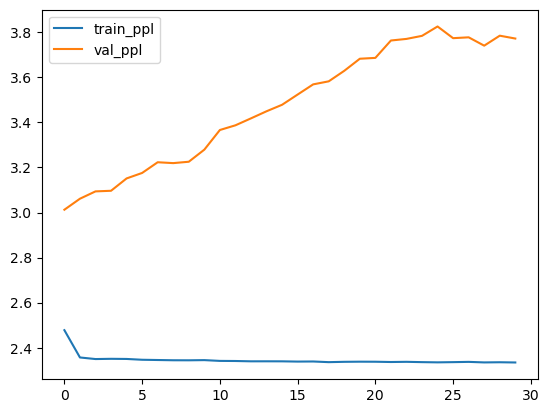

In [92]:
# ADD YOUR CODE HERE

# BEGIN CODE
# This is the part where you should train your FNN_LM model

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialise the model, optimizer, learning rate scheduler (optional), and loss criteria
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# END CODE
# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno
# BEGIN CODE
model_dir = 'BadrinathSinghal_23302/fnn'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
# print(vocab.get_itos())
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        model_dir=model_dir,
        vocab=vocab)
# END CODE
# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

### Eval

In [93]:
eval_ngram_model(trainer, ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

EVALUATION probability distribution is valid: True


Perplexity: 3.5917913913726807
EVALUATION of 2-gram on valid perplexity: 3.5917913913726807
EVALUATION 2-gram generated names are <s>baj</s>, <s>ark</s>, <s>snr</s>, <s>ier</s>, <s>mns</s>
EVALUATION 2-gram generated names with prefix <s><s>sh are <s><s>sh</s>, <s><s>sh</s>, <s><s>sh</s>, <s><s>sh</s>, <s><s>sh</s>
EVALUATION 2-gram generated names with prefix <s><s>na are <s><s>na</s>, <s><s>na</s>, <s><s>na</s>, <s><s>na</s>, <s><s>na</s>
EVALUATION 2-gram generated names with prefix <s><s>da are <s><s>da</s>, <s><s>da</s>, <s><s>da</s>, <s><s>da</s>, <s><s>da</s>
EVALUATION 2-gram generated names with prefix <s><s>ki are <s><s>ki</s>, <s><s>ki</s>, <s><s>ki</s>, <s><s>ki</s>, <s><s>ki</s>
EVALUATION 2-gram generated names with prefix <s><s>ra are <s><s>ra</s>, <s><s>ra</s>, <s><s>ra</s>, <s><s>ra</s>, <s><s>ra</s>
EVALUATION 2-gram generated names with prefix <s><s>de are <s><s>de</s>, <s><s>de</s>, <s><s>de</s>, <s><s>de</s>, <s><s>de</s>
EVALUATION 2-gram generated names with pref

Load your saved model and generate a few names

In [45]:
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

# ADD YOUR CODE HERE
# BEGIN CODE
# change the directory name with your SAPname and SRno

folder = 'BadrinathSinghal_23302/fnn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=None,
        criterion=None,
        train_dataloader=None,
        valid_dataloader=None,
        epochs=None,
        use_cuda=USE_CUDA,
        model_dir=None,
        vocab=vocab)

# Generate a few names
names = trainer.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['a','a','s','h'])
print(", ".join(names))
# END CODE

# you may use this block to test if your model and vocab load properly,
# and that your functions are able to generate sentences, calculate perplexity etc.

aashs</s>, aashhmymnlrhmgnmgk</s>, aashm</s>, aashlbn</s>, aash</s>


In [46]:
# Release models we don't need any more.
del trainer
del model

## 2.2 Recurrent Neural Networks for Language Modelling

For this stage of the assignment, you will implement an RNN language model.

Some tips:
* use dropout
* use the same weights for the embedding layer and the pre-softmax layer
* train with Adam


In [47]:
"""
Implemenation of a PyTorch Module that holds the RNN

"""
class RNN_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(RNN_LM, self).__init__()
        # BEGIN CODE
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.model_hidden_dim = hidden_dim
        # END CODE

    def forward(self, x):
        # BEGIN CODE
        # print("input x shape: {}".format(x.shape))
        embedded = self.embedding(x)
        # print("embedded shape: {}".format(embedded.shape))
        output, hidden = self.rnn(embedded)
        # print("output shape: {}, hidden shape: {}".format(output.shape, hidden.shape))
        output = self.fc(output)
        # print("final output shape: {}".format(output.shape))
        
        return output.squeeze(), hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        # END CODE

In [48]:
class RNNTrainer:
    """
    RNNTrainer wraps RNN_LM to handle training and evaluation.

    """

    # NOTE: you are free to add additional inputs/functions
    # to RNNTrainer to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir,
        ngram
    ):

        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab
        self.ngram = ngram

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()

    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        # ADD YOUR CODE HERE FOR TRAINING & VALIDATION

        # BEGIN CODE
        hidden = np.random.randn(self.model.model_hidden_dim)

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            for batch_idx, (data, target) in enumerate(self.train_dataloader):
                if self.use_cuda:
                    data, target = data.cuda(), target.cuda()
                self.optimizer.zero_grad()
                output, hidden = self.model(data)
                # print("output shape: {}, target shape: {}".format(output.shape, target.shape))
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_dataloader)
            self.loss["train"].append(train_loss)

            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data, target in self.valid_dataloader:
                    if self.use_cuda:
                        data, target = data.cuda(), target.cuda()
                    output, hidden = self.model(data)
                    loss = self.criterion(output, target)
                    val_loss += loss.item()
            val_loss /= len(self.valid_dataloader)
            self.loss["val"].append(val_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

        # Save the trained model
        # print("Saving the model at: {}".format(self.model_dir))
        # torch.save(self.model.cpu().state_dict(), self.model_dir)
        self.save_model()
        self.save_loss()

    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    # END CODE
    # def next_char_probabilities(self):
    #     """
    #     Save train/val loss as json file to the directory

    #     """

    #     loss_path = os.path.join(self.model_dir, "loss.json")
    #     with open(loss_path, "w") as fp:
    #         json.dump(self.loss, fp)


    #     next_char_probabilities = {}

    #     # Set the model to evaluation mode
    #     self.model.eval()

    #     # Loop through each character in the vocabulary
    #     for char in self.vocab:
    #         # Create a tensor with the default starting sequence and the current character
    #         inputs = torch.tensor([[self.vocab[START], self.vocab[char]]], dtype=torch.long)

    #         # Move the tensor to the GPU if available
    #         if self.use_cuda:
    #             inputs = inputs.cuda()

    #         # Pass the tensor through the model to get the output probabilities
    #         outputs, hidden = self.model(inputs)

    #         # Extract the probability of the next character from the output probabilities
    #         next_char_probability = outputs[0, 0, self.vocab[char]].item()

    #         # Add the character and its probability to the dictionary
    #         next_char_probabilities[char] = next_char_probability

    #     return next_char_probabilities


    def generate_names(self, k, n, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list[str]]
        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        # don't forget self.model.eval()
        names = []

        # Set the model to evaluation mode
        self.model.eval()

        # Loop k times to generate k names
        for _ in range(k):
            # Initialize an empty list to store the tokens of the generated name
            generated_name = ['<s>']

            # If a prefix is provided, add its tokens to the generated_name list
            if prefix:
                generated_name.extend(prefix)

            # Loop until the length of the generated_name list is less than n or the last token is not END
            while len(generated_name) < n:
                if len(generated_name)>0 and generated_name[-1] != END:
                    break
                # Create a tensor with the tokens in the generated_name list
                inputs = torch.tensor([generated_name], dtype=torch.long)

                # Move the tensor to the GPU if available
                if self.use_cuda:
                    inputs = inputs.cuda()

                # Pass the tensor through the model to get the output probabilities
                outputs, hidden = self.model(inputs)

                # Sample the next token based on the output probabilities
                next_token = torch.multinomial(outputs[0, -1], 1).item()

                # If the sampled token is not END, add it to the generated_name list
                if next_token != self.vocab[END]:
                    generated_name.append(next_token)

            # Add the generated name to the names list
            names.append("".join(generated_name))
            # names.append(generated_name)
        # END CODE
        # Return the list of generated names
        return names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'a', 'a', 'b', 'i', 'd', '</s>'],
            ['<s>', 'a', 'a', 'b', 'i', 'd', 'a', '</s>']]

        Returns:
            perplexity [float]

        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        # you may want to use the dataloader here
        # don't forget self.model.eval()

        total_loss = 0.0
        total_tokens = 0

        # Set the model to evaluation mode
        self.model.eval()

        # Loop through each tokenized name in the text list
        for name in text:
            # Convert the tokenized name to a tensor of indices
            inputs = torch.tensor([self.vocab[token] for token in name], dtype=torch.long)

            # Move the tensor to the GPU if available
            if self.use_cuda:
                inputs = inputs.cuda()

            # Pass the tensor through the model to get the output probabilities
            outputs, hidden = self.model(inputs)

            # Calculate the cross-entropy loss between the output probabilities and the target tokens
            # print(outputs.shape, inputs.shape)
            loss = self.criterion(outputs.view(-1, len(self.vocab)), inputs.unsqueeze(0).view(-1))

            # Add the loss to the total_loss
            total_loss += loss.item()

            # Add the number of tokens in the tokenized name to the total_tokens
            total_tokens += len(name) - 1

        # Calculate the perplexity as the exponential of the average loss per token
        perplexity = torch.exp(torch.tensor(total_loss / total_tokens))
        # END CODE
        # Return the perplexity
        return perplexity.item()
        # return perplexity
    

    # Probability for the next character 
    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]*(ngram-1)
        Example:
            If ngram=3, then default starting sequence for which
            probabilities have to be returned is
            [START, START]

        Returns:
            dictionary with key: char, value: probability

        """

        # ADD YOUR CODE HERE
        # BEGIN CODE
        self.model.eval()

        # Initialize the sequence with [START]*(ngram-1)
        sequence = [self.vocab['<START>']] * (self.ngram - 1)

        # Convert the sequence to a tensor and move it to GPU if available
        sequence_tensor = torch.tensor(sequence).unsqueeze(0)
        if self.use_cuda:
            sequence_tensor = sequence_tensor.cuda()

        # Forward pass to get the logits
        logits, hidden = self.model(sequence_tensor)

        # Convert logits to probabilities using softmax
        # print(logits.shape)
        probabilities = F.softmax(logits)

        # Convert probabilities to a dictionary with char as key and probability as value
        next_char_probabilities = {}
        for i, prob in enumerate(probabilities.squeeze().tolist()):
            next_char_probabilities[self.vocab.get_itos()[i]] = prob

        # END CODE
        return next_char_probabilities



    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        # ADD YOUR CODE HERE

        # BEGIN CODE

        # don't forget self.model.eval()
        
        most_likely_chars = []

        # Convert the input sequence of characters to a tensor of indices
        inputs = torch.tensor([self.vocab[char] for char in sequence], dtype=torch.long)

        # Move the tensor to the GPU if available
        if self.use_cuda:
            inputs = inputs.cuda()

        # Pass the tensor through the model to get the output probabilities
        outputs, hidden = self.model(inputs)

        # Get the last output probabilities corresponding to the last character in the sequence
        last_output = outputs[-1]

        # Sort the probabilities in descending order and get the indices of the top k probabilities
        top_k_indices = torch.argsort(last_output, descending=True)[:k]

        # Convert the indices back to characters using the vocab dictionary
        most_likely_chars = [self.vocab.get_itos()[idx.item()] for idx in top_k_indices]

        # Return the list of most likely characters

        # END CODE
        return most_likely_chars


In [49]:
"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# BEGIN CODE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

MAX_NAME_LENGTH = 10 # maximum length of name for generation

# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

EPOCHS = 30
BATCH_SIZE = 32
SHUFFLE = True # if dataset should be shuffled
# END CODE
# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# create the dataloaders for training and validation

# ADD YOUR CODE HERE
# BEGIN CODE
N_GRAM_LENGTH=2
train_dataloader = get_dataloader(train_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = get_dataloader(validation_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# END CODE

GPU is available: True
131


In [50]:
# ADD YOUR CODE HERE

# BEGIN CODE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialize the model
# you may want to pass arguments to RNN_LM based on your implementation
vocab_size = len(vocab.get_stoi()) # 131
embedding_dim = 128
hidden_dim = 64
num_layers = 2 
# END CODE
model = RNN_LM(vocab_size, embedding_dim, hidden_dim, num_layers)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

# Initialise the optimizer, learning rate scheduler (optional), and loss criteria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno
# BEGIN CODE
model_dir = 'BadrinathSinghal_23302/rnn'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.

trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        vocab=vocab,
        model_dir=model_dir,
        ngram=2
        )
# END CODE
# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Epoch 1/30, Train Loss: 2.485217172547901, Val Loss: 2.8972898721694946
Epoch 2/30, Train Loss: 2.3558366078259523, Val Loss: 2.98668057200135
Epoch 3/30, Train Loss: 2.346237829209297, Val Loss: 3.018522298493922
Epoch 4/30, Train Loss: 2.342765403509371, Val Loss: 3.0665838521047935
Epoch 5/30, Train Loss: 2.3423559103676794, Val Loss: 3.1103736213500928
Epoch 6/30, Train Loss: 2.3388688219251383, Val Loss: 3.1595440791142697
Epoch 7/30, Train Loss: 2.337290375299629, Val Loss: 3.198644319117464
Epoch 8/30, Train Loss: 2.3362945972546028, Val Loss: 3.2367009279743724
Epoch 9/30, Train Loss: 2.336576800955692, Val Loss: 3.2799100844275872
Epoch 10/30, Train Loss: 2.3348787012081758, Val Loss: 3.3178090113677725
Epoch 11/30, Train Loss: 2.3345518977690527, Val Loss: 3.360809591037548
Epoch 12/30, Train Loss: 2.335398588845252, Val Loss: 3.409833112299837
Epoch 13/30, Train Loss: 2.3333511087116636, Val Loss: 3.4411109970105405
Epoch 14/30, Train Loss: 2.3340181566969584, Val Loss: 3.49

### Eval

In [51]:
## Please do not change anything in this code block.

def eval_rnn_model(model, ds, ds_name, eval_prefixes, eval_sequences, num_names=5):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model, 1, True)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of RNN on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH))
    print(f'EVALUATION RNN generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION RNN generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION RNN the top most likely chars after {sequence} are {most_likely_chars}")

In [52]:
eval_rnn_model(trainer, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

/tmp/ipykernel_971964/3264712894.py:297: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(logits)


EVALUATION probability distribution is valid: True
EVALUATION of RNN on valid perplexity: 2.969669818878174
EVALUATION RNN generated names are <s>, <s>, <s>, <s>, <s>
EVALUATION RNN generated names with prefix <s><s>sh are <s><s><s>sh, <s><s><s>sh, <s><s><s>sh, <s><s><s>sh, <s><s><s>sh
EVALUATION RNN generated names with prefix <s><s>na are <s><s><s>na, <s><s><s>na, <s><s><s>na, <s><s><s>na, <s><s><s>na
EVALUATION RNN generated names with prefix <s><s>da are <s><s><s>da, <s><s><s>da, <s><s><s>da, <s><s><s>da, <s><s><s>da
EVALUATION RNN generated names with prefix <s><s>ki are <s><s><s>ki, <s><s><s>ki, <s><s><s>ki, <s><s><s>ki, <s><s><s>ki
EVALUATION RNN generated names with prefix <s><s>ra are <s><s><s>ra, <s><s><s>ra, <s><s><s>ra, <s><s><s>ra, <s><s><s>ra
EVALUATION RNN generated names with prefix <s><s>de are <s><s><s>de, <s><s><s>de, <s><s><s>de, <s><s><s>de, <s><s><s>de
EVALUATION RNN generated names with prefix <s><s>ni are <s><s><s>ni, <s><s><s>ni, <s><s><s>ni, <s><s><s>ni, <s><s

In [53]:
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno
# BEGIN CODE
folder = 'BadrinathSinghal_23302/rnn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")
# END CODE
# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        model_dir=folder,
        ngram=2,
        vocab=vocab)

# Generate a few names
names = trainer.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['a','a','s','h'])
print(", ".join(names))

# you may use this block to test if your model and vocab load properly,
# and that your functions are able to generate sentences, calculate perplexity etc.

<s>aash, <s>aash, <s>aash, <s>aash, <s>aash


In [54]:
# Release models we don't need any more.
del trainer
del model

# Congratulations!

You've reacehd the end of the assignment. Hope this was a pleasant and fun exercise!

Check the submission instructions mentioned at the begining of the notebook in order to submit your homework.
